In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import re
from sklearn.cluster import KMeans


In [2]:
BASE_URL = '''http://www.vogue.com/fashion-shows/{}-{}/{}#collection'''
REGEX_BASE = '''http:\/\/assets.vogue.com\/photos\/[a-f0-9]*\/master\/pass\/'''

class CollectionDownloader(object):
    '''
    Class to download all images from a single runway show on vogue.com
    '''

    def __init__(self, designer, season, year):
        self.designer = '-'.join(designer.split()).lower()
        self.season = season.lower()
        self.year = str(year)
        self.two_digit_year = str(year)[-2:]
        print "connecting to site"
        self.response = self.get_response()
        self.storage_path = '../data/{}-{}-{}'.format( \
                                              self.designer,
                                              self.two_digit_year,
                                              self.season
                                             )
        
        self.image_urls = set(re.findall(self.build_regex(), self.response))
        
        print "downloading images"
        self.image_folder = self.save_images()


    def get_response(self):
        '''
        collect html from collection landing page
        '''
        self.landing_url = BASE_URL.format( \
                                            self.season, 
                                            self.year, 
                                            self.designer
                                          )
                                        
        return requests.get(self.landing_url).text
    
    
    
    def build_regex(self):    
        '''
        format regex to search for image assets
        '''
        
        return '''http:\/\/assets.vogue.com\/photos\/[a-f0-9]*\/master\/pass\/''' + \
                '[0-9]{1,3}-[a-z-]+?-[0-9]{0,2}' + self.two_digit_year + '.jpg'
                
    
       
    def save_images(self):
        if not os.path.exists(self.storage_path):
            os.makedirs(self.storage_path)
        for i, url in enumerate(self.image_urls):
            image_data = requests.get(url).content
            file_name = '/{}-{}-{}-{}.jpg'.format( \
                                                 str(i).zfill(3), 
                                                 self.designer,
                                                 self.season,
                                                 self.two_digit_year
                                                )
            with open('{}{}'.format(self.storage_path, file_name), "w+") as f:
                print "Gather image ", i
                f.write(image_data)
                f.close()                                

                

In [3]:
lemlem17 = CollectionDownloader("lemlem", "resort", 2017)

connecting to site
downloading images
Gather image  0
Gather image  1
Gather image  2
Gather image  3
Gather image  4
Gather image  5
Gather image  6
Gather image  7
Gather image  8
Gather image  9
Gather image  10
Gather image  11
Gather image  12
Gather image  13
Gather image  14
Gather image  15
Gather image  16
Gather image  17
Gather image  18
Gather image  19
Gather image  20


In [4]:
lemlem18 = CollectionDownloader("lemlem", "resort", 2018)

connecting to site
downloading images
Gather image  0
Gather image  1
Gather image  2
Gather image  3
Gather image  4
Gather image  5
Gather image  6
Gather image  7
Gather image  8
Gather image  9
Gather image  10
Gather image  11
Gather image  12
Gather image  13
Gather image  14
Gather image  15
Gather image  16
Gather image  17
Gather image  18
Gather image  19
Gather image  20
Gather image  21
Gather image  22
Gather image  23


In [5]:
def kmeans_palette_combined(folder, n_colors, sample_size = 5000, seed = 17):
    kmeans_collection = []
    print "processing images"
    for f in os.listdir(folder):
        
        if f.endswith('jpg'):
            kmeans_palette = kmeans_palette_one_image(n_colors, '{}/{}'.format(folder, f))
            kmeans_collection.append(kmeans_palette)
    collected_colors = [model.cluster_centers_ for model in kmeans_collection]
    colors_flat = [item for l in collected_colors for item in l]
        
    return KMeans(n_clusters=n_colors/2, random_state=seed).fit(colors_flat)     
            
            
def kmeans_palette_one_image(n_colors, image_path, sample_size = 5000, seed = 17):
    '''
    image passed as a path to jpg. untested with other file formats.
    '''
    im = plt.imread(image_path)
    im = np.array(im, dtype=np.float64) / 255
    
    w, h, colors = im.shape
    image_flat = np.reshape(im, (w * h, colors))
        
    if len(image_path) > sample_size:
        sample_size = len(image_path)
        
    random.seed(seed)
    sample = random.sample(image_flat, sample_size)

    return KMeans(n_clusters=n_colors, random_state=seed).fit(sample)
       

In [6]:
def make_palette_uniform_width(colors, title, figsize=(8,4)):
    plt.figure(figsize=figsize)
    start = 0
    cur = start
    w = 1./len(colors)
    for c in colors:        
        plt.axvspan(cur, cur+w, color=c)
        cur += w
    plt.title(title)
    plt.axis([0, 1, 0, 1])
    plt.axis('off')
    plt.show()
    
    
    

processing images


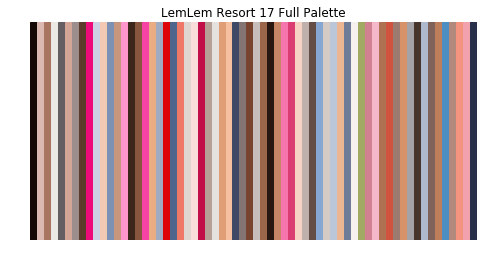

In [7]:
ll_17_full_palette = kmeans_palette_combined(lemlem17.storage_path, 128).cluster_centers_
make_palette_uniform_width(ll_17_full_palette, "LemLem Resort 17 Full Palette")

processing images


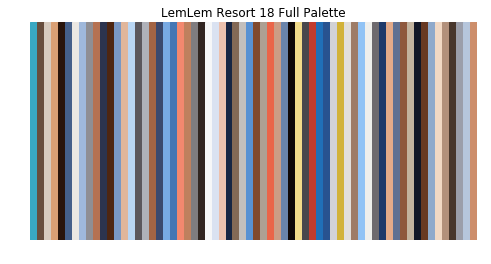

In [8]:
ll_18_full_palette = kmeans_palette_combined(lemlem18.storage_path, 128).cluster_centers_
make_palette_uniform_width(ll_18_full_palette, "LemLem Resort 18 Full Palette")

In [9]:
def show_images_with_lines(path):
    '''
    this is just to demonstrate that these four point are a reasonable approximation of the background
    in images with a one- or two-part background'''

    for f in os.listdir(path)[:5]:
        if f.endswith('jpg'):
            im = plt.imread(path + f)
            h, w, c = im.shape
            plt.axhline(h/8)
            plt.axhline(7*h/8)
            plt.axvline(w/8)
            plt.axvline(7*w/8)
            plt.axvline(w/2)
            plt.imshow(im)
            plt.show()
            
    
    

In [10]:
def find_background_palette(path, num_images_to_check = 4):
    background_colors = []
    for f in random.sample(os.listdir(path), num_images_to_check):
        if f.endswith('jpg'):
            im = plt.imread('{}/{}'.format(path, f))
            im = np.array(im, dtype=np.float64) / 255
            h, w, colors = im.shape
            #locate points at 1/8 of height and width away from border of image - top & bottom, left & right
            corners = [(h/8, w/8), (h/8, 7*w/8), (7*h/8, w/8), (7*h/8, 7*w/8)]
            for row, col in corners:
                color_block = im[row-4:row+4, col-4:col+4]
                ave_color = [avg_each_color(color_block, color) for color in ['r', 'g', 'b']]
                background_colors.append(ave_color)

    return background_colors


def avg_each_color(color_block, color):
    color_dict = {'r':0, 'g':1, 'b':2}
    index = color_dict[color]
    all_colors = [color[index] for row in color_block for color in row]
    ave_color = sum(all_colors)/len(all_colors)
    return ave_color

def check_swatch(color):
    print color
    plt.figure(figsize=(2,1))
    plt.axvspan(.0, 1, color=color)
    plt.axis([0, 1, 0, 1])
    plt.show()

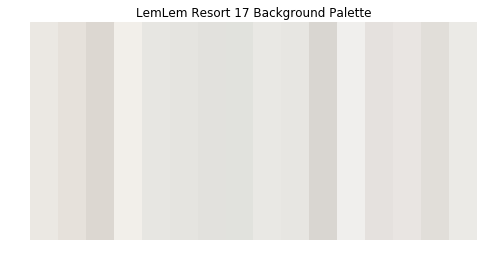

In [11]:
ll_17_bg_palette = find_background_palette(lemlem17.storage_path)
make_palette_uniform_width(ll_17_bg_palette, "LemLem Resort 17 Background Palette")

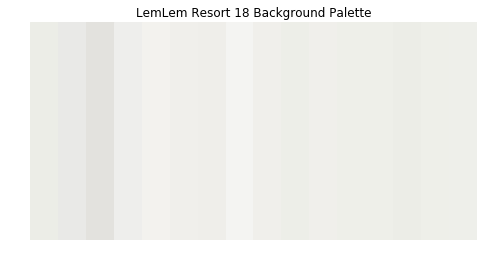

In [12]:
ll_18_bg_palette = find_background_palette(lemlem18.storage_path)
make_palette_uniform_width(ll_18_bg_palette, "LemLem Resort 18 Background Palette")

In [29]:
def find_skin_palette(path_to_image_dir, path_to_open_cv, num_images_to_check=8, num_points_to_check=4): 
    face_colors = []
    for f in random.sample(os.listdir(path_to_image_dir), num_images_to_check):
        if f.endswith('jpg'):
            face = find_face('{}/{}'.format(path_to_image_dir, f), path_to_open_cv)
            if face is not None:

                h, w, colors = face.shape
                face = np.array(face, dtype=np.float64) / 255
                for _ in range(num_points_to_check):
                    col = np.random.randint(8,w-8)
                    row = np.random.randint(8,h-8)
                    color_block = face[row-4:row+4, col-4:col+4]

                    ave_color = [avg_each_color(color_block, color) for color in ['r', 'g', 'b']]
                    face_colors.append(ave_color)

    return face_colors

def find_face(img_file, path_to_opencv):
    '''
    uses OpenCV's face recognition tool to draw conclusions re: skin colors of models
    '''
    path = path_to_opencv + 'data/haarcascades/haarcascade_frontalface_default.xml'

    cascade = cv2.CascadeClassifier(path)

                              
    im = cv2.imread(img_file)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
    w, h = im_gray.shape
    min_size = (w/20, h/20)
    
    face = cascade.detectMultiScale(im_gray, 1.1, 5, minSize=min_size)
    
    if len(face) == 0:
            color_block = None
    else:
        for (x,y,w,h) in face:
            color_block = im_rgb[y:y+h, x:x+w]

    return color_block

In [30]:
path_to_opencv = ''


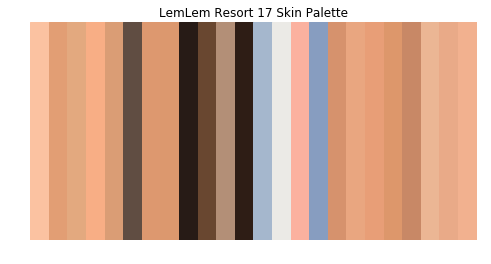

In [31]:
ll_17_skin_palette = find_skin_palette(lemlem17.storage_path, path_to_opencv)
make_palette_uniform_width(ll_17_skin_palette, "LemLem Resort 17 Skin Palette")

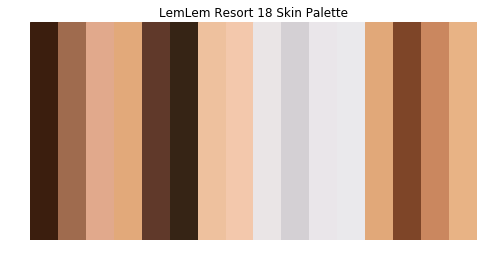

In [33]:
ll_18_skin_palette = find_skin_palette(lemlem18.storage_path, path_to_opencv)
make_palette_uniform_width(ll_18_skin_palette, "LemLem Resort 18 Skin Palette")

In [34]:
def remove_colors_from_palette(full_palette, background_palette, thresh = 0.1):
    all_remove = []
    color_series = full_palette
    for color in background_palette:
        color_series = find_within_threshold(color, color_series, thresh)      
    return color_series


    
def find_within_threshold(anchor_color, color_series, thresh = 0.1):
    to_remove = []
    for i, color in enumerate(color_series):
        #print color
        if np.allclose(anchor_color, color, thresh):
            temp = np.concatenate((color_series[:i],(color_series[i+1:])))
            color_series = temp
            continue
    return color_series


In [35]:
def get_garment_palette(full_pal, bg_pal, sk_pal, bg_thresh = 0.01, sk_thresh = 0.15):
    temp1 = remove_colors_from_palette(full_pal, bg_pal, bg_thresh)
    garm_pal = remove_colors_from_palette(temp1, sk_pal, sk_thresh)
    return garm_pal

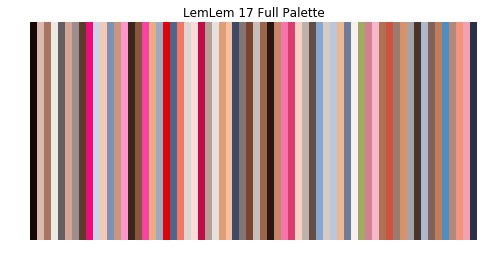

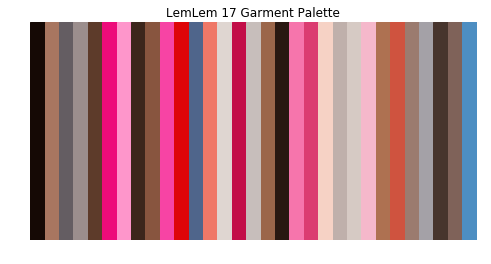

In [36]:
ll_17_garm_pal = get_garment_palette(ll_17_full_palette, ll_17_bg_palette, ll_17_skin_palette)
make_palette_uniform_width(ll_17_full_palette, "LemLem 17 Full Palette")
make_palette_uniform_width(ll_17_garm_pal, "LemLem 17 Garment Palette")

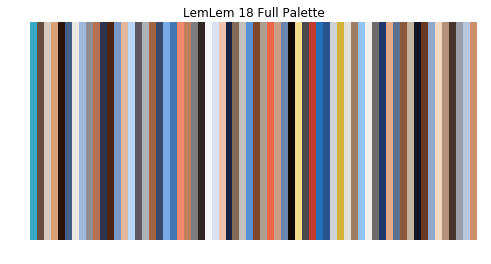

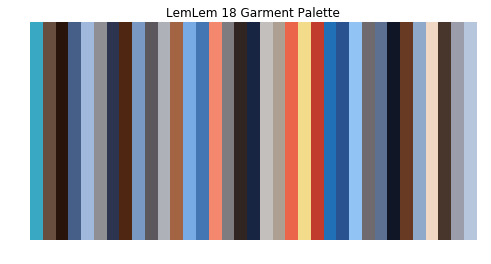

In [37]:
ll_18_garm_pal = get_garment_palette(ll_18_full_palette, ll_18_bg_palette, ll_18_skin_palette)
make_palette_uniform_width(ll_18_full_palette, "LemLem 18 Full Palette")
make_palette_uniform_width(ll_18_garm_pal, "LemLem 18 Garment Palette")